In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/Masters_Team_Project_Final/Machine_Learning'
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive/Masters_Team_Project_Final/Machine_Learning


In [2]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from heapq import nlargest
import traceback

In [4]:
df = pd.read_excel("Journal_500Dataset.xlsx")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  500 non-null    object
 1   er_strat      480 non-null    object
 2   adaptive      429 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [ ]:
df = df[df['er_strat'].notna()]

df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  480 non-null    object
 1   er_strat      480 non-null    object
 2   adaptive      429 non-null    object
dtypes: object(3)
memory usage: 11.4+ KB


Model trained: LogisticRegression
F1 Score for LogisticRegression: 0.1279


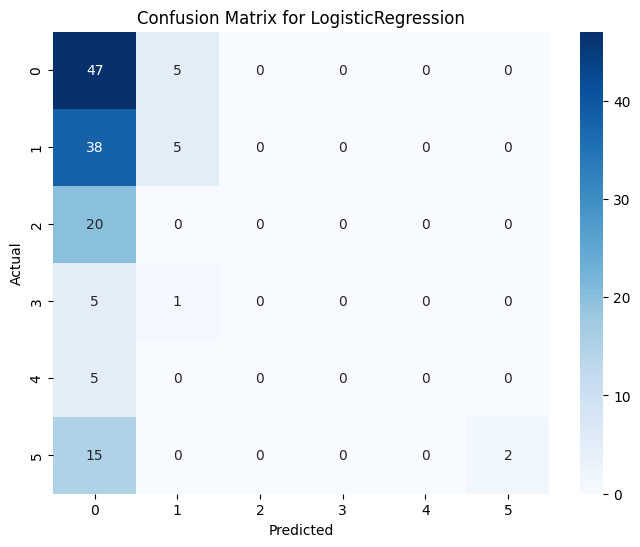

Model trained: RandomForest
F1 Score for RandomForest: 0.2235


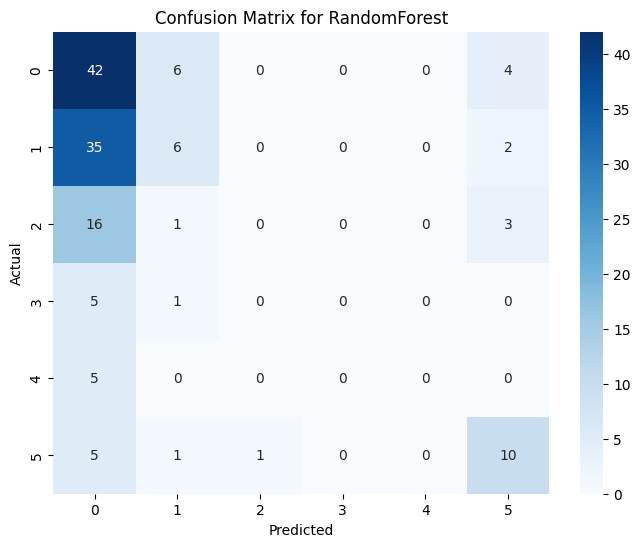

Model trained: SVM
F1 Score for SVM: 0.2707


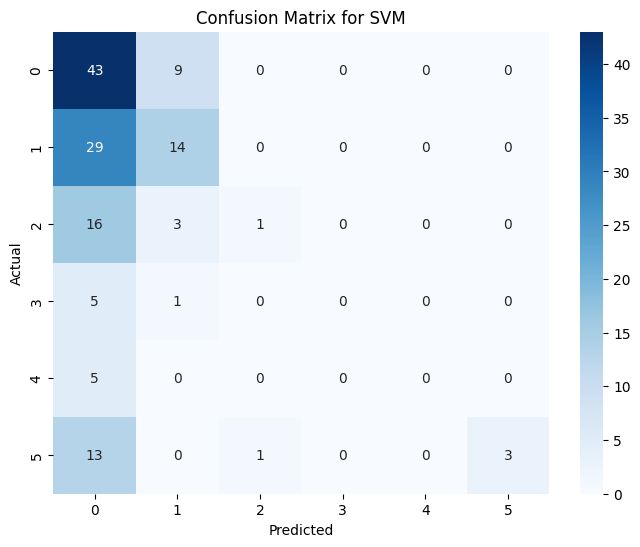

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Model trained: AdaBoost
F1 Score for AdaBoost: 0.3726


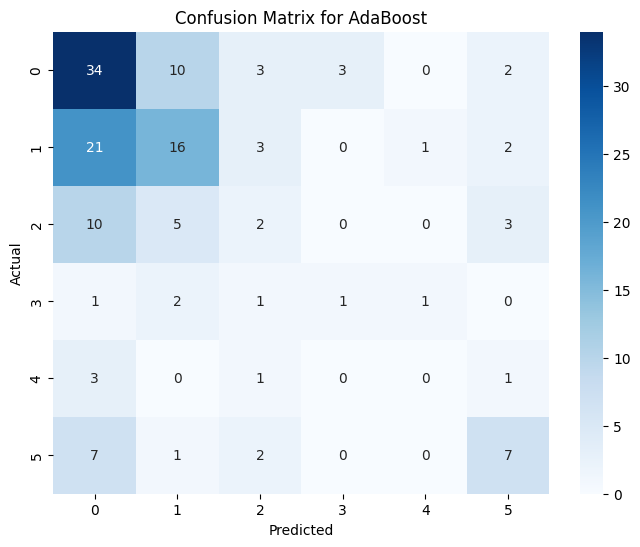

Model trained: NaiveBayes
F1 Score for NaiveBayes: 0.0000


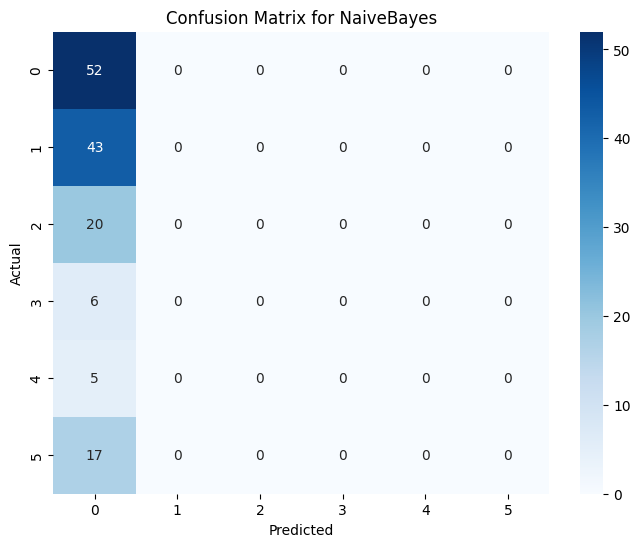

Model trained: KNN
F1 Score for KNN: 0.1820


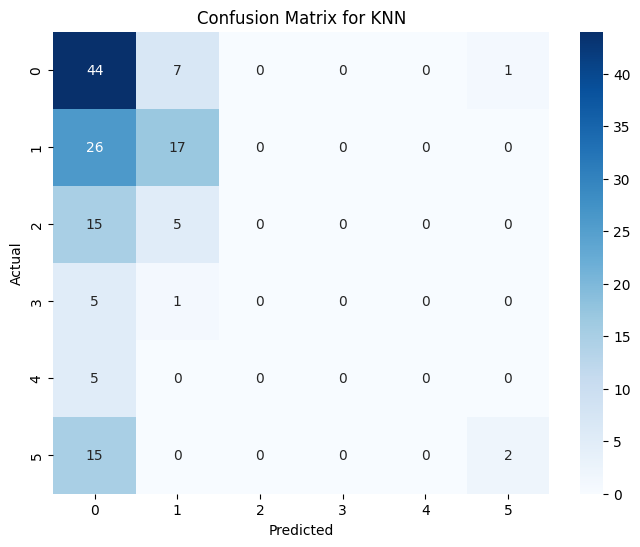

Model trained: DecisionTree
F1 Score for DecisionTree: 0.3565


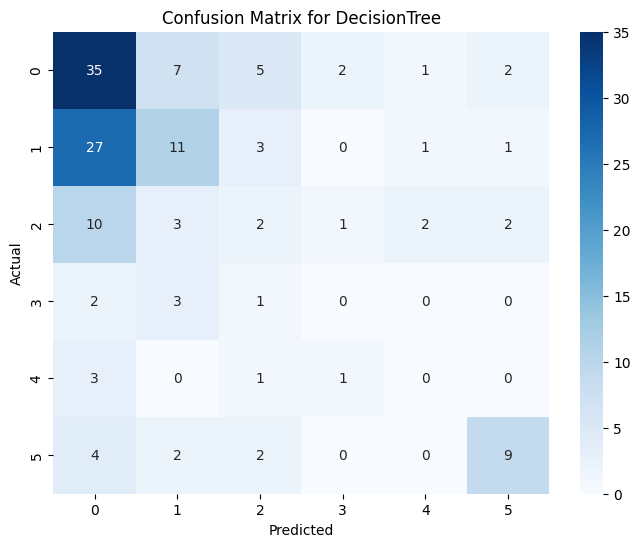

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from heapq import nlargest
import traceback
from sklearn.metrics import f1_score, confusion_matrix

# TF-IDF Vectorization
def tfidf_vectorizer(X_train, X_test):
    try:
        vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1, 2))
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        joblib.dump(vectorizer, "tfidf_vectorizer.sav")
        return X_train, X_test
    except Exception as e:
        print(f"Error in TF-IDF Vectorization: {e}")
        traceback.print_exc()

# Classification Report Generator
def classification_report_generator(y_true, y_pred, model_name):
    try:
        report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
        pd.DataFrame(report).transpose().to_csv(f"{model_name}_classification_report.csv")
        return report
    except Exception as e:
        print(f"Error generating classification report: {e}")
        traceback.print_exc()

# Confusion Matrix Generator
def confusion_matrix_generator(y_true, y_pred, model_name):
    try:
        # Convert to numpy arrays if needed
        y_true_array = np.asarray(y_true.argmax(axis=1))
        y_pred_array = np.asarray(y_pred.argmax(axis=1))

        cm = confusion_matrix(y_true_array, y_pred_array)

        labels = mlb.classes_
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"{model_name}_confusion_matrix.png")
        plt.close()  # Close the plot to free memory
    except Exception as e:
        print(f"Error generating confusion matrix: {e}")
        traceback.print_exc()

# Macro F1 Tracker
macro_f1 = {}

# Train and Evaluate Models
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)
        print(f"Model trained: {model_name}")

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred, average="weighted")
        print(f"F1 Score for {model_name}: {f1:.4f}")

        # Generate and display confusion matrix
        y_test_array = np.asarray(y_test.argmax(axis=1))  # Ensure y_test is a numpy array
        y_pred_array = np.asarray(y_pred.argmax(axis=1))  # Ensure y_pred is a numpy array

        cm = confusion_matrix(y_test_array, y_pred_array)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()  # Display confusion matrix plot

    except Exception as e:
        print(f"Error in training or evaluating {model_name}: {e}")
# Main Script
try:
    # Load Dataset
    file_path = "Dataset500.xlsx"  # Update file path
    df = pd.read_excel(file_path)
    df = df[df['er_strat'].notna()]
      # Drop rows with missing labels
    df["labels"] = df["er_strat"].apply(lambda x: x.split(", "))  # Split labels into lists

    # Encode Labels
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df["labels"])
    X = df["text_cleaned"]

    # Train-Test Split
    X_train, y_train, X_test, y_test = iterative_train_test_split(
        np.array(X).reshape(-1, 1), y, test_size=0.3
    )
    X_train, X_test = X_train.ravel(), X_test.ravel()

    # Vectorize Text
    X_train, X_test = tfidf_vectorizer(X_train, X_test)

    # Initialize Models
    models = {
        "LogisticRegression": BinaryRelevance(LogisticRegression(max_iter=3000)),
        "RandomForest": BinaryRelevance(RandomForestClassifier(random_state=42)),
        "SVM": BinaryRelevance(SVC(kernel="linear", probability=True)),
        "AdaBoost": BinaryRelevance(AdaBoostClassifier(n_estimators=100)),
        "NaiveBayes": BinaryRelevance(MultinomialNB()),
        "KNN": BinaryRelevance(KNeighborsClassifier(n_neighbors=15)),
        "DecisionTree": BinaryRelevance(DecisionTreeClassifier()),
    }

    # Train and Evaluate
    for name, model in models.items():
        train_and_evaluate(model, name, X_train, y_train, X_test, y_test)

except Exception as e:
    print(f"Error in main script: {e}")
    traceback.print_exc()


In [ ]:
print("Class names:", mlb.classes_)

Class names: ['Attentional Deployment' 'Cognitive Change' 'Response Modulation'
 'Situation Modification' 'Situation Selection' 'none']


In [ ]:
df = pd.read_excel("Dataset500.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  500 non-null    object
 1   er_strat      480 non-null    object
 2   adaptive      429 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [ ]:
df = df[df['er_strat'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 2 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  480 non-null    object
 1   er_strat      480 non-null    object
 2   adaptive      429 non-null    object
dtypes: object(3)
memory usage: 15.0+ KB


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split the labels by comma and transform into a list of labels
df['Labels'] = df['er_strat'].str.split(', ')

# Initialize MultiLabelBinarizer to convert the labels into binary format
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Labels'])

# Convert the binary labels into a DataFrame with proper column names
y_df = pd.DataFrame(y, columns=mlb.classes_)

# Now y_df contains binary columns for each class label
print(y_df)

     Attentional Deployment  Cognitive Change  Response Modulation  \
0                         0                 1                    0   
1                         0                 0                    0   
2                         0                 0                    1   
3                         0                 0                    0   
4                         0                 0                    0   
..                      ...               ...                  ...   
475                       0                 0                    1   
476                       1                 0                    0   
477                       1                 0                    0   
478                       0                 0                    1   
479                       0                 0                    0   

     Situation Modification  Situation Selection  none  
0                         0                    0     0  
1                         1                  